In [164]:
import numpy as truenp

import matplotlib.pyplot as plt
import matplotlib.cm as color
better_magma = color.magma
better_magma.set_bad('black',1.)
import matplotlib.colors as c

from prysm import (
    mathops, 
    conf,
)
from prysm.mathops import (
    np,
    fft,
    interpolate,
    ndimage,
)
from prysm.coordinates import (
    make_xy_grid, 
    cart_to_polar,
)
from prysm.propagation import Wavefront as WF
from prysm.thinlens import (
    defocus_to_image_displacement,
    image_displacement_to_defocus,
)
from prysm.geometry import (
    circle,
    spider,
)
from prysm.polynomials import (
    noll_to_nm,
    zernike_nm,
    zernike_nm_seq,
    hopkins,
    sum_of_2d_modes
)
mathops.set_backend_to_cupy()
conf.config.precision = 32

from astropy.io import (
    fits,
    ascii,
)

from lina.phase_retrieval import ADPhaseRetireval, ParallelADPhaseRetrieval

from psd_utils import PSDUtils

from scipy.optimize import minimize
from scipy.interpolate import RegularGridInterpolator

from bbpr.models import raytrace
from bbpr.scipts import ADPhaseRetireval, ParallelADPhaseRetrieval

import tomlkit

from tqdm import tqdm

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [165]:
with open("config_wcc_pearl_base.toml", mode="rt", encoding="utf-8") as f:
    cfg = tomlkit.load(f)

In [170]:
class WCC_fraunhofer:

    def __init__(self, config):

        ##### MODEL SETUP #####

        self.config = config

        # sampling parameters
        self.npix = int(config['simulation']['beam_sampling'])  # beam sampling [pix]
        self.fov = int(config['simulation']['fov'])             # FOV on detector [pix]

        # get model wavelengths from reference wavlength/bandwidth
        wvl0 = float(config['simulation']['wvl_reference']) * 1e6   # ref wavelength [m -> um]
        bw = float(config['simulation']['bandwidth'])               # bandwidth as a fraction of ref wavelength
        n_wvl = int(config['simulation']['wvl_sampling'])           # number of wavelengths to sample the spectrum
        self.wvls = np.linspace(wvl0 - wvl0 * bw / 2, wvl0 + wvl0 * bw / 2, n_wvl)

        # throughput calculation
        self.throughput = np.ones((len(self.wvls),))

        for optic in cfg['optics'].keys():

            # get path to coating data from config
            path1 = config['coat_path']
            path2 = config['optics'][str(optic)]['coating']
            
            # load reflectivity curve and create interpolator
            coat_data = ascii.read(path1 + path2)
            wvl = coat_data.columns[0].data
            refl = coat_data.columns[1].data
            refl_interp = interpolate.PchipInterpolator(wvl, refl)

            # interp for model wavelengths and multiply into throughput
            self.throughput *= refl_interp(self.wvls * 1e3) # wvls [um -> nm] to match reflectivity curve units

        # source parameters
        self.src_mags = np.array(config['sources']['magnitudes'])       # magnitudes [Rmag]
        self.src_pos = np.array(config['sources']['positions']) / 60    # positions [arcmin -> deg]
        self.defocus_vals = np.array(config['sources']['defocus_vals']) # defocus [waves]
        self.defocus_vals *= wvl0 * 1e3                                 # waves -> nm

        # use raytrace to include geometric aberrations?
        self.field_aber = []
        if bool(config['use_raytrace']) is True:
            self.raytrace = raytrace.telescope(wavelength=wvl0, npix_pupil=self.npix + 4) # add extra padding for raytrace
            for pos in self.src_pos:
                field_opd = np.array(self.raytrace.get_opd(fieldX=pos[0].get(), fieldY=pos[1].get())[2:-2, 2:-2]) # cut off extra padding
                self.field_aber.append(field_opd * 1e9) # [m -> nm]
        else:
            self.raytrace = None
            for pos in self.src_pos:
                self.field_aber.append(np.zeros((self.npix, self.npix)))
        
        # pupil parameters
        D_pupil = float(config['pupil']['diam']) * 1000             # diameter [m -> mm]
        D_obs = float(config['pupil']['diam_obscuration']) * 1000   # M2 obsurcation diameter [m -> mm]
        D_support = float(config['pupil']['support_width']) * 1000  # M2 support width [m -> mm]
        n_support = int(config['pupil']['num_supports'])            # number of M2 supports

        # pupil grids
        self.x_pup, self.y_pup = make_xy_grid(self.npix, diameter=D_pupil)
        self.r_pup, self.t_pup = cart_to_polar(self.x_pup, self.y_pup)

        # pupil pixelscale
        self.dx_pup = D_pupil / self.npix               

        # pupil mask
        self.pupil = circle(radius=D_pupil / 2, r=self.r_pup)
        if D_obs > 0:
            self.pupil = self.pupil ^ circle(radius=D_obs / 2, r=self.r_pup)
        if n_support > 0:
            self.pupil = self.pupil & spider(vanes=n_support, width=D_support, x=self.x_pup, y=self.y_pup)

        # defocus map  
        r_pup_norm = self.r_pup / (D_pupil / 2)
        self.defocus_map = hopkins(0, 2, 0, r_pup_norm, self.t_pup, 0) 

        # grab f/# and EFL
        fno = float(config['fno'])  # working f/#
        self.efl = fno * D_pupil    # effective focal length [mm]

        # optic OPDs
        self.opds = []

        for optic in cfg['optics'].keys():

            # get beam diameter on optic
            D_beam = float(config['optics'][str(optic)]['beam_size']) # meters

            # get path to OPD data
            path1 = config['opds_path']
            path2 = config['optics'][str(optic)]['opd_map']
            
            # load OPD map and grab header
            hdr = fits.getheader(path1 + path2)
            opd_data = fits.getdata(path1 + path2)

            # get pixelscale and dimensions
            pixscl = hdr['PIXELSCL']
            dim = opd_data.shape[0]

            # create input grid and interpolator for OPD map
            x_i = y_i = truenp.linspace(-pixscl * dim / 2, pixscl * dim / 2, dim)
            opd_interp = RegularGridInterpolator((x_i, y_i), opd_data)

            # create output grid and interpolate to match beam sampling in pupil
            x_f = y_f = truenp.linspace(-D_beam / 2, D_beam / 2, self.npix) # meters
            x_f, y_f = truenp.meshgrid(x_f, y_f, indexing='ij')
            self.opds.append(np.array(opd_interp((x_f, y_f))))

   
        # detector parameters
        self.exp_time = float(config['detector']['exposure_time'])          # exposure time [s]
        self.dx_detector = float(config['detector']['pixel_size']) * 1e6    # detector pixel pitch [m -> um]
        self.detector_gain = float(config['detector']['gain'])              # detector gain setting
        self.black_lvl = float(config['detector']['black_level'])           # detector black level (ADU offset)
        temp_detector = float(config['detector']['temp_nominal'])           # detector temperature [celsius]
        path1 = config['cam_path']                                          # path to detector data files

        # get QE and apply to throughput
        path2 = config['detector']['qe']
        qe_data = fits.getdata(path1 + path2)
        qe_data = np.array([list(x) for x in qe_data])  
        qe_interp = interpolate.PchipInterpolator(qe_data[:, 0], qe_data[:, 1])
        self.throughput *= qe_interp(self.wvls * 1e3) # wvls [um -> nm] to match qe curve units

        # get dark current for detector temp
        path2 = config['detector']['dark_current']
        dark_data = ascii.read(path1 + path2)
        dark_interp = interpolate.PchipInterpolator(dark_data.columns[0].data, dark_data.columns[1].data)
        self.dark_current = dark_interp(temp_detector)

        # get [e-/ADU]/read noise/well depth for gain setting
        path2 = config['detector']['gain_curve']
        gain_data = ascii.read(path1 + path2)
        gain_interp = interpolate.PchipInterpolator(gain_data.columns[0].data, gain_data.columns[1].data)
        self.e_per_adu = gain_interp(self.detector_gain)

        path2 = config['detector']['read_noise']
        read_data = ascii.read(path1 + path2)
        read_interp = interpolate.PchipInterpolator(read_data.columns[0].data, read_data.columns[1].data)
        self.read_noise = read_interp(self.detector_gain)

        path2 = config['detector']['well_depth']
        well_data = ascii.read(path1 + path2)
        well_interp = interpolate.PchipInterpolator(well_data.columns[0].data, well_data.columns[1].data)
        self.well_depth = well_interp(self.detector_gain)

    def set_cam_exposure_time(self, exposure_time):
        self.exp_time = exposure_time

    def set_cam_black_level(self, black_level):
        self.black_lvl = black_level

    def set_cam_gain(self, gain):

        self.detector_gain = gain
        path1 = self.config['cam_path']

        # get [e-/ADU]/read noise/well depth for gain setting
        path2 = self.config['detector']['gain_curve']
        gain_data = ascii.read(path1 + path2)
        gain_interp = interpolate.PchipInterpolator(gain_data.columns[0].data, gain_data.columns[1].data)
        self.e_per_adu = gain_interp(self.detector_gain)

        path2 = self.config['detector']['read_noise']
        read_data = ascii.read(path1 + path2)
        read_interp = interpolate.PchipInterpolator(read_data.columns[0].data, read_data.columns[1].data)
        self.read_noise = read_interp(self.detector_gain)

        path2 = self.config['detector']['well_depth']
        well_data = ascii.read(path1 + path2)
        well_interp = interpolate.PchipInterpolator(well_data.columns[0].data, well_data.columns[1].data)
        self.well_depth = well_interp(self.detector_gain)
        

    def _create_wavefront(self, wvl, src_magnitude, debug=False):
        
        # initialize wavefront
        wavefront = WF.from_amp_and_phase(self.pupil, None, wvl, self.dx_pup)

        # calculate wavefront power
        # using vega flux zero point of 702e10 photons/cm^2/s/m from:
        # https://www.astronomy.ohio-state.edu/martini.10/usefuldata.html
        dx_sq = (self.dx_pup / 10) ** 2                                             # [mm -> cm^2]
        collecting_area = dx_sq * np.sum(self.pupil)                                # [cm^2]
        bandwidth = (self.wvls[-1] - self.wvls[0]) * 1e-6                           # [um -> m]
        flux = 702e10 * collecting_area * bandwidth * 10 ** (-src_magnitude / 2.5)  # [photons/s]

        if debug:
            print(flux)

        # scale wavefront
        wavefront *= np.sqrt(flux / np.sum(np.abs(wavefront.data) ** 2) / len(self.wvls))

        return wavefront


    def _fwd(self, wvl, src_magnitude, field_aber, defocus_val, debug=False):
        
        # initialize wavefront
        pre = self._create_wavefront(wvl, src_magnitude, debug=debug)
        wfs = [pre]

        # loop through optics
        for i, opd in enumerate(self.opds):
            if i != 0:
                pre = post

            # create complex screen to represent the optic
            optic = WF.from_amp_and_phase(amplitude=self.pupil, phase=opd, wavelength=wvl, dx=self.dx_pup)

            # apply optic to the wavefront
            post = pre * optic
            wfs.append(post)

        # apply detector defocus
        defocus = WF.from_amp_and_phase(amplitude=self.pupil, phase=self.defocus_map * -defocus_val, wavelength=wvl, dx=self.dx_pup)
        post_defocus = post * defocus
        wfs.append(post_defocus)

        # apply field aberration from raytrace
        field_aberration = WF.from_amp_and_phase(amplitude=self.pupil, phase=field_aber, wavelength=wvl, dx=self.dx_pup)
        post_field_aber = post_defocus * field_aberration
        wfs.append(post_field_aber)
        
        # fraunhofer prop to detector
        at_detector = post_field_aber.focus_fixed_sampling(efl=self.efl, dx=self.dx_detector, samples=self.fov, shift=(0, 0), method='mdft')
        wfs.append(at_detector)

        if debug:  
            return(wfs)
        
        else:
            return np.abs(at_detector.data) ** 2

    def snap(self,):
        
        # initialize images
        images = []
        
        # loop through sources
        for src_magnitude, field_opd, val in zip(self.src_mags, self.field_aber, self.defocus_vals):
            
            # initialize detector fluxes
            detector_fluxes = []

            # loop through wavelengths
            for wvl in self.wvls.tolist():
                
                # use forward model to get detector flux
                detector_flux = self._fwd(wvl, src_magnitude, field_opd, val)
                detector_fluxes.append(detector_flux)

            # get psf intensity by summing across fluxes while applying throughput/exposure time
            psf_intensity = sum_of_2d_modes(np.array(detector_fluxes), self.throughput) * self.exp_time

            # add photon noise
            psf_with_photon_noise = np.random.poisson(psf_intensity)

            # apply gain
            adu = np.round(np.ones(psf_with_photon_noise.shape) * self.black_lvl + psf_with_photon_noise / self.e_per_adu)

            # add dark current
            adu += np.ones(adu.shape) * self.dark_current * self.exp_time

            # add read noise
            image = np.round(adu + np.random.normal(loc=0, scale=self.read_noise, size=adu.shape))

            # cant read out negative numbers
            image[image < 0] = 0

            # saturate above well depth
            if np.sum(image[image > self.well_depth]) > 0:
                print("WARNING: SATURATED PSF")
                image[image > self.well_depth] = self.well_depth

            images.append(image)

        return images

100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


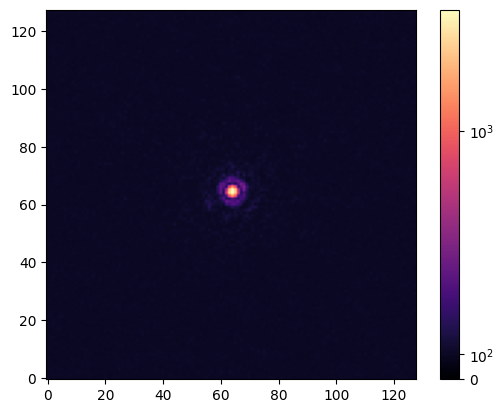

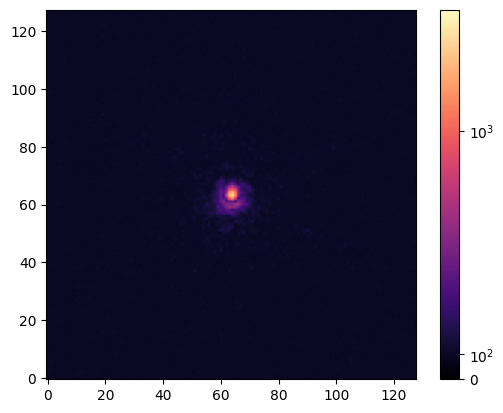

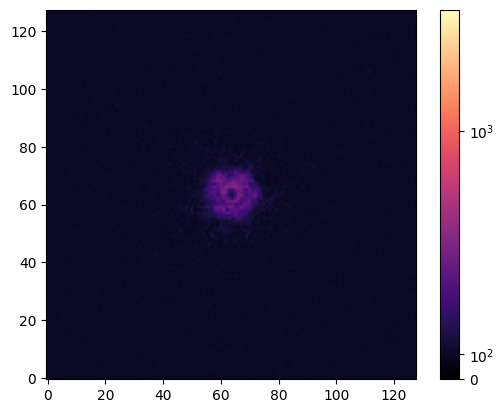

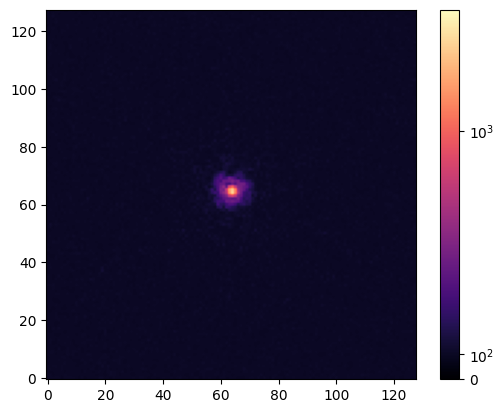

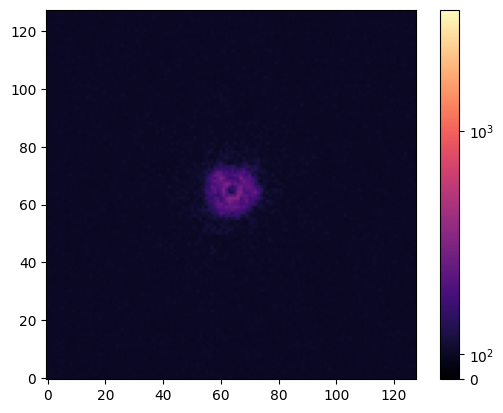

In [173]:
sys =  WCC_fraunhofer(config=cfg)
imnorm = c.SymLogNorm(linthresh=sys.black_lvl, linscale=1e-1, vmin=0)

# quick benchmark 
for i in tqdm(np.arange(10)):
    images = sys.snap()

for image in images:
    plt.figure()
    plt.imshow(image.get(), cmap='magma', norm=imnorm)
    plt.colorbar()

In [46]:
# zernike basis
x, y = make_xy_grid(shape=model.npix, dx=model.dx_m1)
r, t = cart_to_polar(x, y)
r_norm = r / (6420 / 2)
nms = [noll_to_nm(i) for i in range(2, 37)]
zernike_coeffs = list(zernike_nm_seq(nms, r, t, norm=True))
zernikes = [z / np.max(np.abs(z)) for z in zernike_coeffs]

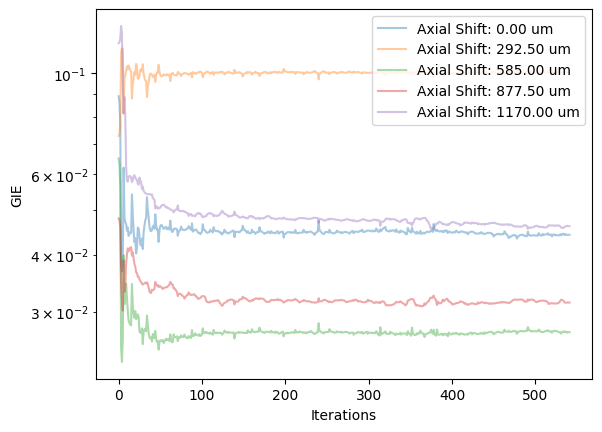

In [47]:
error_fx = 'GIE'
adpr_list = []

for shift, image in zip(axial_shifts, images):
    adpr_list.append(ADPhaseRetireval(amp=model.aperture,
                                          amp_dx=model.dx_m1,
                                          efl=model.efl,
                                          wvls=model.wvls,
                                          basis=np.asarray(zernikes),
                                          target=image,
                                          img_dx=3.76,
                                          axial_shift=shift,
                                          initial_opd=None,
                                          error_function=error_fx))

fdpr = ParallelADPhaseRetrieval(optlist=adpr_list)

results = minimize(fdpr.fg, x0=np.zeros(len(zernike_coeffs)).get(),
                   jac=True, method='L-BFGS-B',
                   options={'maxls': 20, 'ftol': 1e-8, 'gtol': 1e-8, 'disp': 0, 'maxiter':500})

for i, opt in enumerate(fdpr.optlist):
    plt.plot(np.asarray(opt.cost).get(), label=f'Axial Shift: {axial_shifts[i]:0.2f} um', alpha=0.4)
plt.ylabel(error_fx)
plt.xlabel('Iterations')
plt.legend(loc='upper right')
plt.yscale('log')
plt.show()

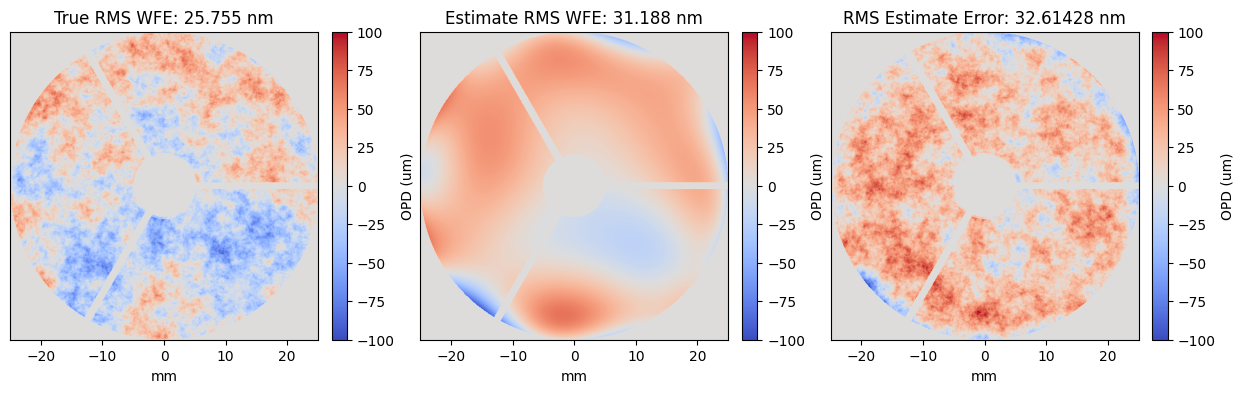

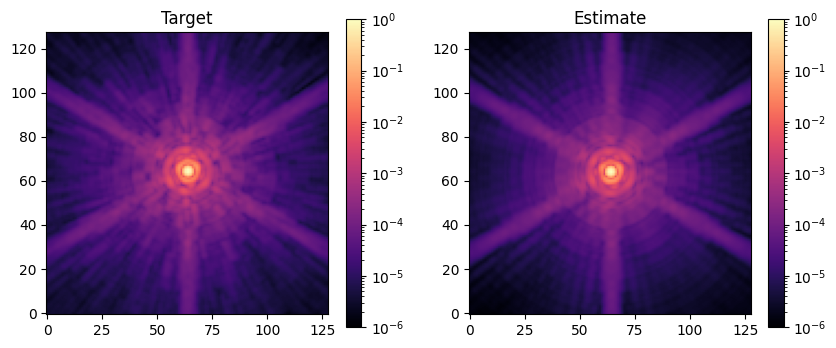

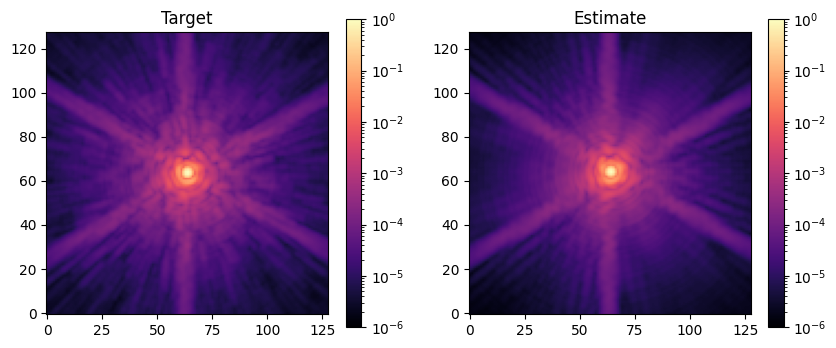

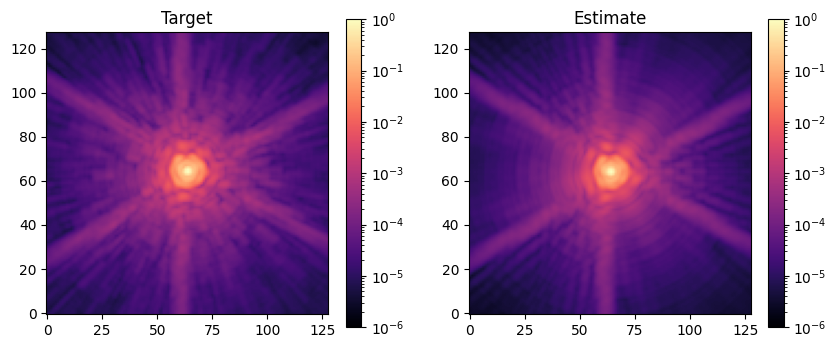

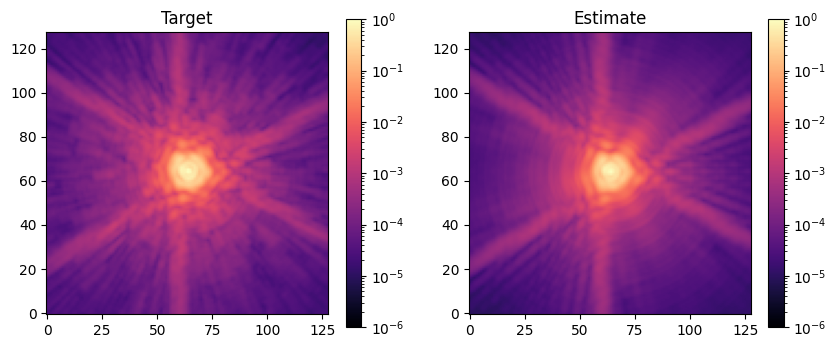

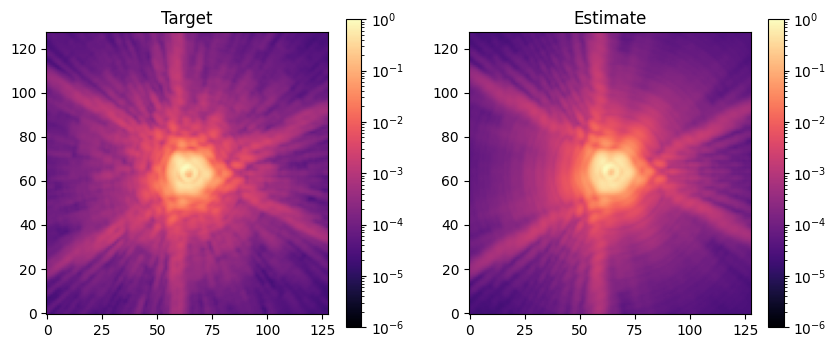

In [48]:
extent_pupil = [-25, 25, -25, 25]
opd_truth = (model.surface_error_m1 + model.surface_error_m2 + model.surface_error_m3 + model.surface_error_m4) * model.aperture
opd_estimate = fdpr.optlist[0].opd * model.aperture

adpr_focus = fdpr.optlist[0]
plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.imshow(opd_truth.get(), extent=extent_pupil, vmin=-100, vmax=100, cmap='coolwarm')
plt.colorbar(pad=0.04, fraction=0.046, label="OPD (um)")
plt.title(f"True RMS WFE: {np.sqrt(np.mean(opd_truth[opd_truth != 0] ** 2)):0.3f} nm")
plt.xlabel("mm"); plt.yticks([])
plt.subplot(132)
plt.imshow(opd_estimate.get(), extent=extent_pupil, vmin=-100, vmax=100, cmap='coolwarm')
plt.colorbar(pad=0.04, fraction=0.046, label="OPD (um)")
plt.title(f"Estimate RMS WFE: {np.sqrt(np.mean(opd_estimate[opd_estimate != 0] ** 2)):0.3f} nm")
plt.xlabel("mm"); plt.yticks([])
opd_diff = opd_estimate - opd_truth
plt.subplot(133)
plt.imshow(opd_diff.get(), extent=extent_pupil, vmin=-100, vmax=100, cmap='coolwarm')
plt.colorbar(pad=0.04, fraction=0.046, label="OPD (um)")
plt.title(f"RMS Estimate Error: {np.sqrt(np.mean(opd_diff[opd_diff != 0] ** 2)):0.5f} nm")
plt.xlabel("mm"); plt.yticks([])

for adpr in fdpr.optlist:
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.title('Target')
    plt.imshow(adpr.D.get() / adpr.D.get().max(), norm='log', cmap='magma', vmin=1e-6)
    plt.colorbar()
    plt.subplot(122)
    plt.title('Estimate')
    plt.imshow(adpr.I.get() / adpr.I.get().max(), norm='log', cmap='magma', vmin=1e-6)
    plt.colorbar()
    plt.show()